In [1]:
library(devtools)
library(ggridges)
library(dplyr)
library(tidyr)
library(ggplot2)
library(quantmod)
library(xts)
library(zoo)
library(gridExtra)
library(tidyverse)
library(tibble)
library(grid)
library(DescTools)
library(rcompanion)

set.seed(1)
load_all("../vendor/hmmTMB")
source("markets_functions.R")  # adjust path if the notebook’s cwd differs

Loading required package: usethis


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: xts

Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric



######################### Warning from 'xts' package ##########################
#                                                                             #
# The dplyr lag() function breaks how base R's lag() function is supposed to  #
# work, which breaks lag(my_xts). Calls to lag(my_xts) that you type or       #
# source() into this session won't work correctly.                            #
#                                                                             #
# Use stats::lag() to make sure you're not using dplyr::lag(), or you can add #
# conflictRules('dplyr', ex

Warning message:
“CL=F contains missing values. Some functions will not work if objects contain missing values in the middle of the series. Consider using na.omit(), na.approx(), na.fill(), etc to remove or replace them.”
Warning message:
“GC=F contains missing values. Some functions will not work if objects contain missing values in the middle of the series. Consider using na.omit(), na.approx(), na.fill(), etc to remove or replace them.”
Warning message:
“HG=F contains missing values. Some functions will not work if objects contain missing values in the middle of the series. Consider using na.omit(), na.approx(), na.fill(), etc to remove or replace them.”
Warning message:
“CAD=X contains missing values. Some functions will not work if objects contain missing values in the middle of the series. Consider using na.omit(), na.approx(), na.fill(), etc to remove or replace them.”
Dropping columns with NA fraction > 0.15: Canada_Utilities_Index, Canada_Consumer_Staples_Index, Canada_Health_

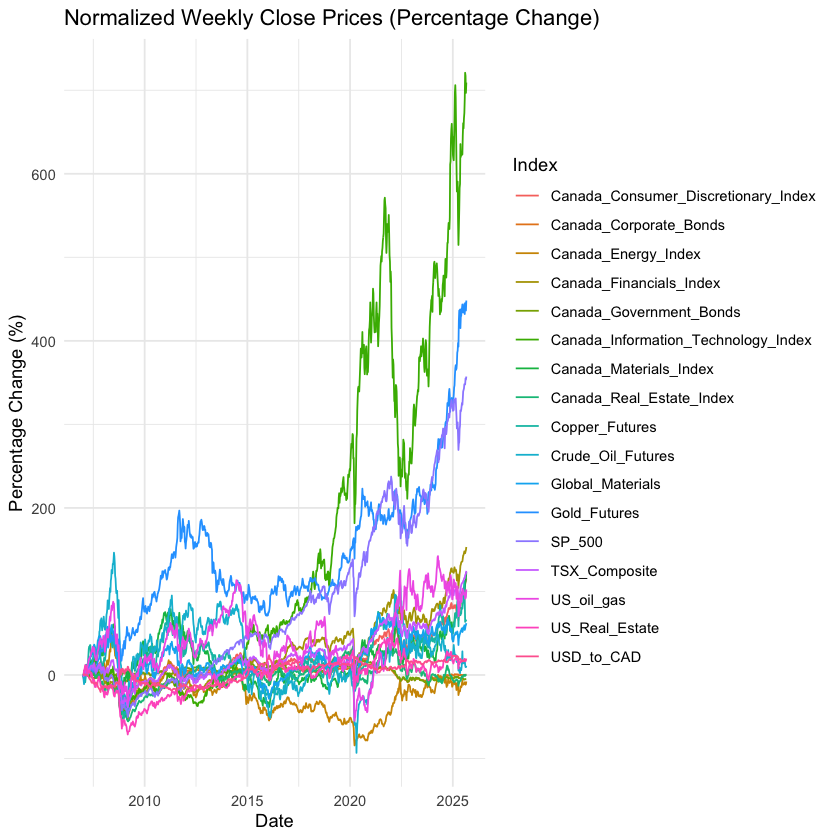

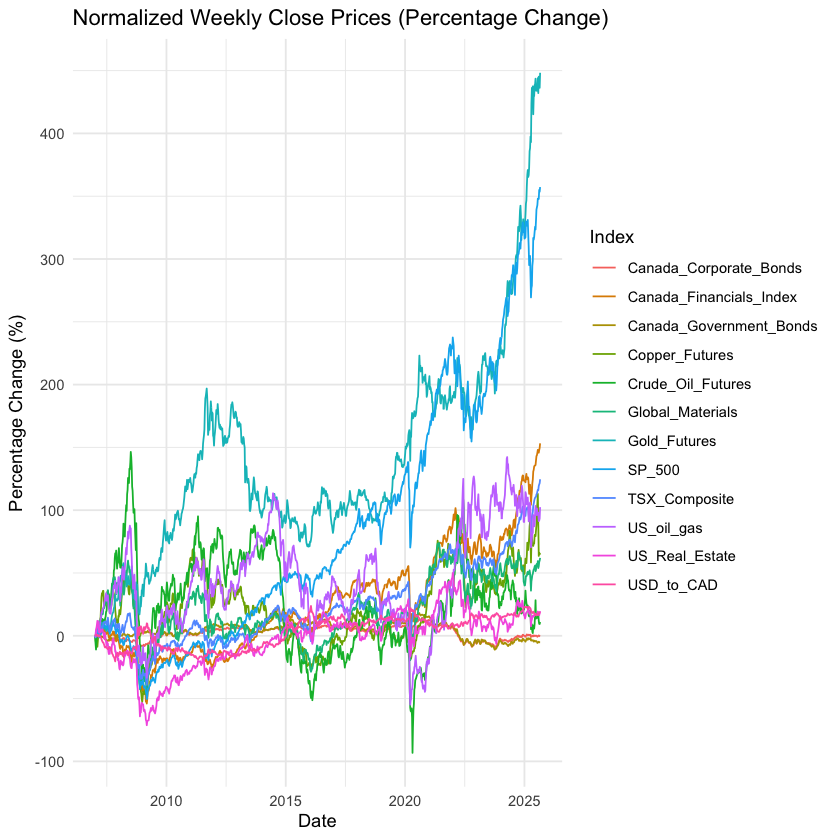

In [2]:
close_data <- get_markets_data("2007-01-01", "2025-09-01", "weeks", plot=TRUE)

close_data <- close_data %>%
  select(Date, 
    TSX_Composite, Canada_Financials_Index,
    Crude_Oil_Futures, Gold_Futures, Copper_Futures,
    USD_to_CAD, Canada_Corporate_Bonds,
    Canada_Government_Bonds, US_oil_gas, Global_Materials,
    US_Real_Estate, SP_500,
  )

close_data_log <- ln_transform(close_data)

# Reshape data for ggplot
close_data_long <- close_data %>%
  pivot_longer(-Date, names_to = "Index", values_to = "Close") %>%
  group_by(Index) %>%
  mutate(Close = (Close / first(Close) - 1) * 100)

# Plot using ggplot2
ggplot(close_data_long, aes(x = Date, y = Close, color = Index)) +
  geom_line() +
  labs(title = "Normalized Weekly Close Prices (Percentage Change)", x = "Date", y = "Percentage Change (%)") +
  theme_minimal()


In [3]:
state_list <- list()  # Initialize an empty list to collect state vectors
par_list <- list()  # Initialize an empty list to collect parameters
models <- list()  # Initialize an empty list to collect models
recoded_states_list <- list()  # Initialize an empty list to collect recoded states
corelation_window <- which.min(abs(close_data$Date - as.Date("2021-05-01")))
corelation_data <- close_data_log[1:corelation_window, ]
for (col in setdiff(colnames(corelation_data), "Date")) {  # Exclude 'Date' directly
  hmm_model <- fit_hmm(
    n_states = 3,
    data = corelation_data,
    obs_name = col,
    hid_formula = as.formula("~1"),
    horseshoe = FALSE,
    init = NULL
  )
  states <- hmm_model$states()  # Extract states as a vector

  obs_par <- matrix(hmm_model$obs()$par(), ncol = 2, byrow = TRUE)  # Extract observation parameters
  obs_par <- cbind(obs_par, matrix(table(append(states, c(1, 2, 3))), ncol = 1))
  colnames(obs_par) <- c("mean", "sd", "count")

  high_var_state <- which.max(obs_par[, "sd"])
  growth_state <- which.max(obs_par[, "mean"])
  mid_state <- setdiff(1:3, c(high_var_state, growth_state))

  state_labels <- c("high_variance", "mid", "growth")[match(1:3, c(high_var_state, mid_state, growth_state))]
  obs_par <- cbind(obs_par, state_label = state_labels)

  # Recode states: -1 = high variance, 0 = mid, 1 = growth
  recoded_states <- sapply(states, function(s) {
    if (s == high_var_state) {
      return(-1)
    } else if (s == growth_state) {
      return(1)
    } else {
      return(0)
    }
  })
  state_list[[col]] <- states   # Add to list with column name as key
  recoded_states_list[[col]] <- recoded_states
  par_list[[col]] <- obs_par
  models[[col]] <- hmm_model
}

# Combine the list into a data frame
state_df <- do.call(cbind.data.frame, state_list)
recoded_df <- do.call(cbind.data.frame, recoded_states_list)

# View the first few rows
head(state_df, 3)
head(recoded_df, 3)

Warning message in hmm$fit(silent = TRUE):
“Convergence code was not zero, indicating that the optimizer may not have converged to the correct estimates. Please check by consulting the out() function which shows what nlminb returned.”
Warning message in hmm$fit(silent = TRUE):
“Convergence code was not zero, indicating that the optimizer may not have converged to the correct estimates. Please check by consulting the out() function which shows what nlminb returned.”


,TSX_Composite,Canada_Financials_Index,Crude_Oil_Futures,Gold_Futures,Copper_Futures,USD_to_CAD,Canada_Corporate_Bonds,Canada_Government_Bonds,US_oil_gas,Global_Materials,US_Real_Estate,SP_500
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,3,3,2,2,2,3,3,3,3,3,2,3
2,3,3,2,2,2,3,3,3,3,3,2,3
3,3,3,2,2,2,3,3,3,3,3,2,3


,TSX_Composite,Canada_Financials_Index,Crude_Oil_Futures,Gold_Futures,Copper_Futures,USD_to_CAD,Canada_Corporate_Bonds,Canada_Government_Bonds,US_oil_gas,Global_Materials,US_Real_Estate,SP_500
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,1,0,1,1,0,1,0,1,1,0,1
2,1,1,0,1,1,0,1,0,1,1,0,1
3,1,1,0,1,1,0,1,0,1,1,0,1


Computing CDFs... done
Computing residuals for Gold_Futures ... done
Computing CDFs... done
Computing residuals for TSX_Composite ... done


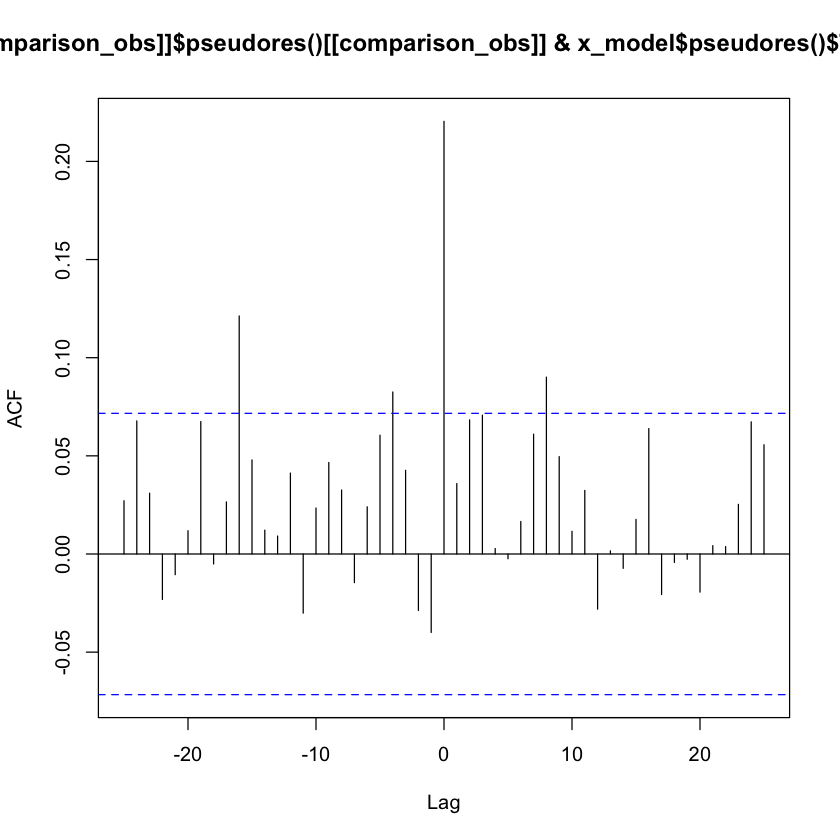

In [4]:
comparison_obs <- "Gold_Futures"
x_model <- fit_hmm(
  n_states = 3,
  data = corelation_data,
  obs_name = "TSX_Composite",
  hid_formula = as.formula("~1"),
  horseshoe = FALSE,
  init = models[[comparison_obs]]
)

ccf(
  x=models[[comparison_obs]]$pseudores()[[comparison_obs]],
  y=x_model$pseudores()$TSX_Composite,
  lag.max = 25, type = "correlation"
)

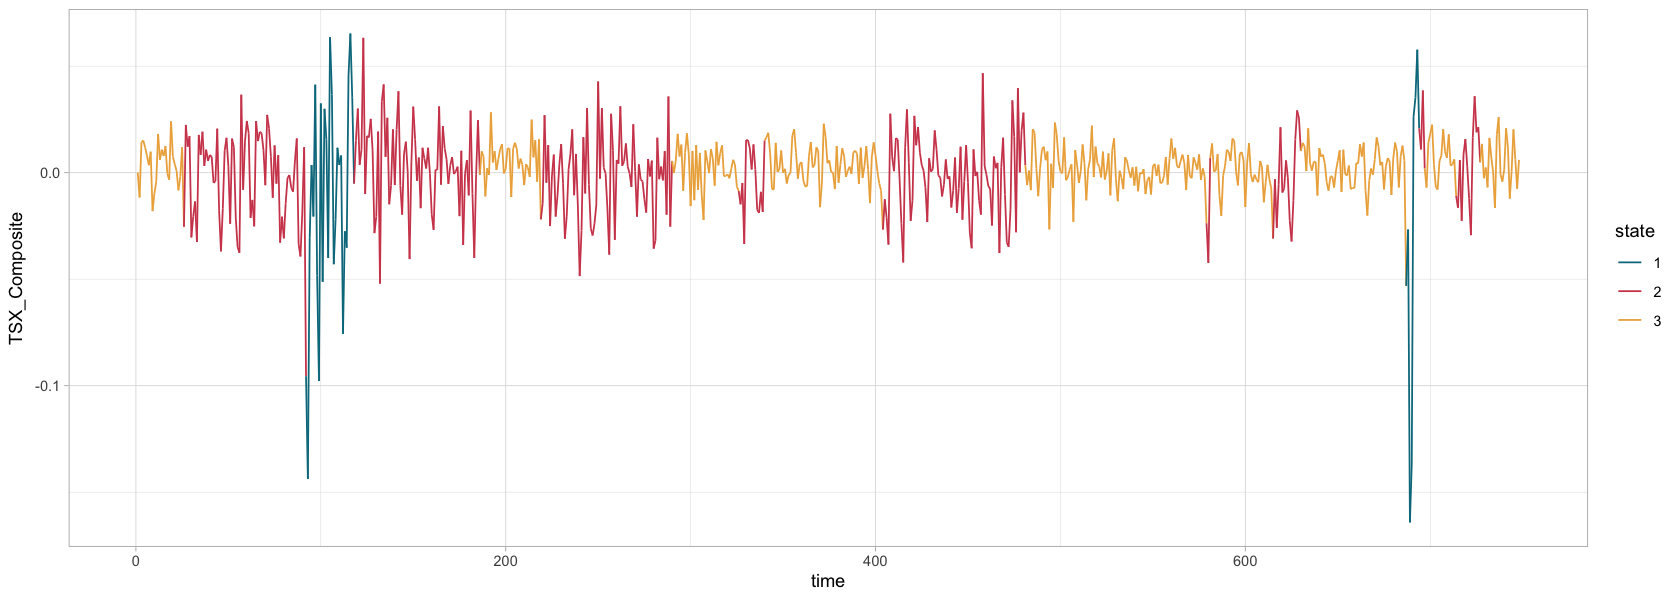

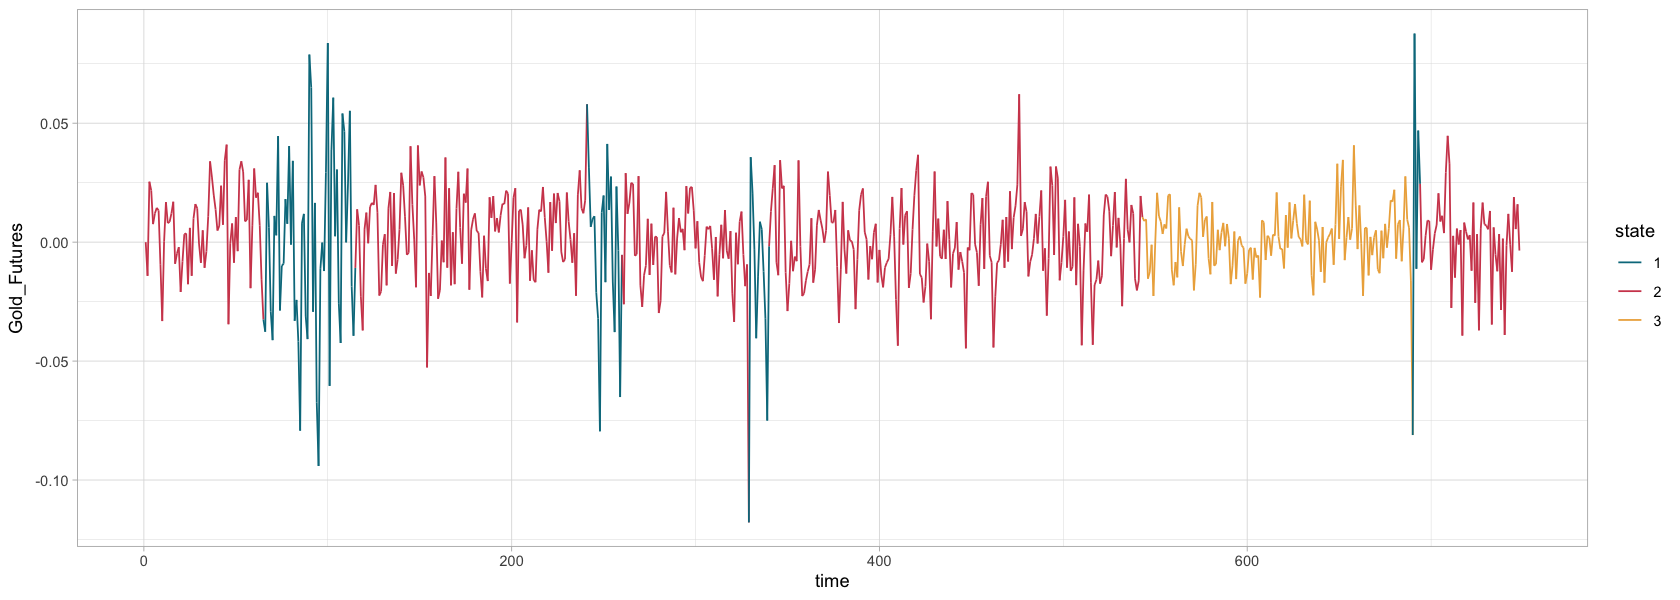

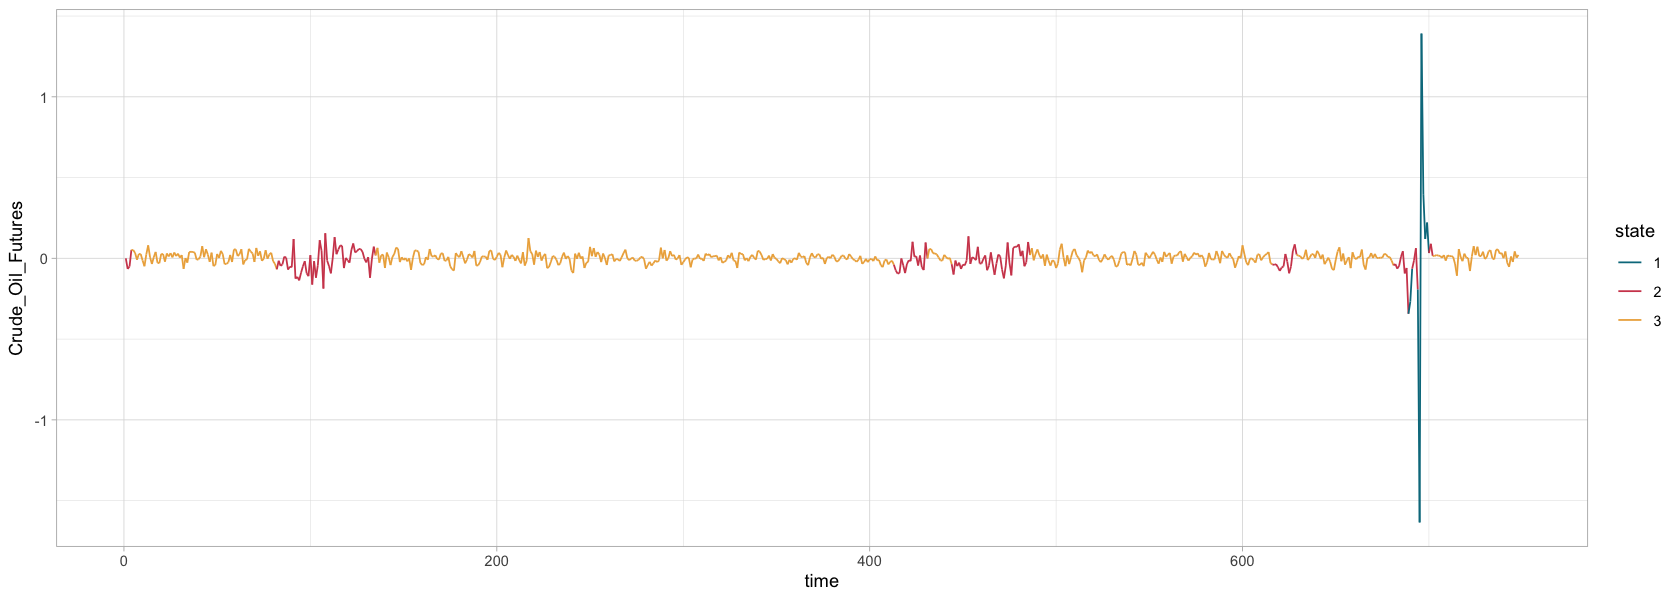

In [5]:
options(repr.plot.width = 14, repr.plot.height = 5)
models$TSX_Composite$plot_ts("TSX_Composite")
models$Gold_Futures$plot_ts("Gold_Futures")
models$Crude_Oil_Futures$plot_ts("Crude_Oil_Futures")

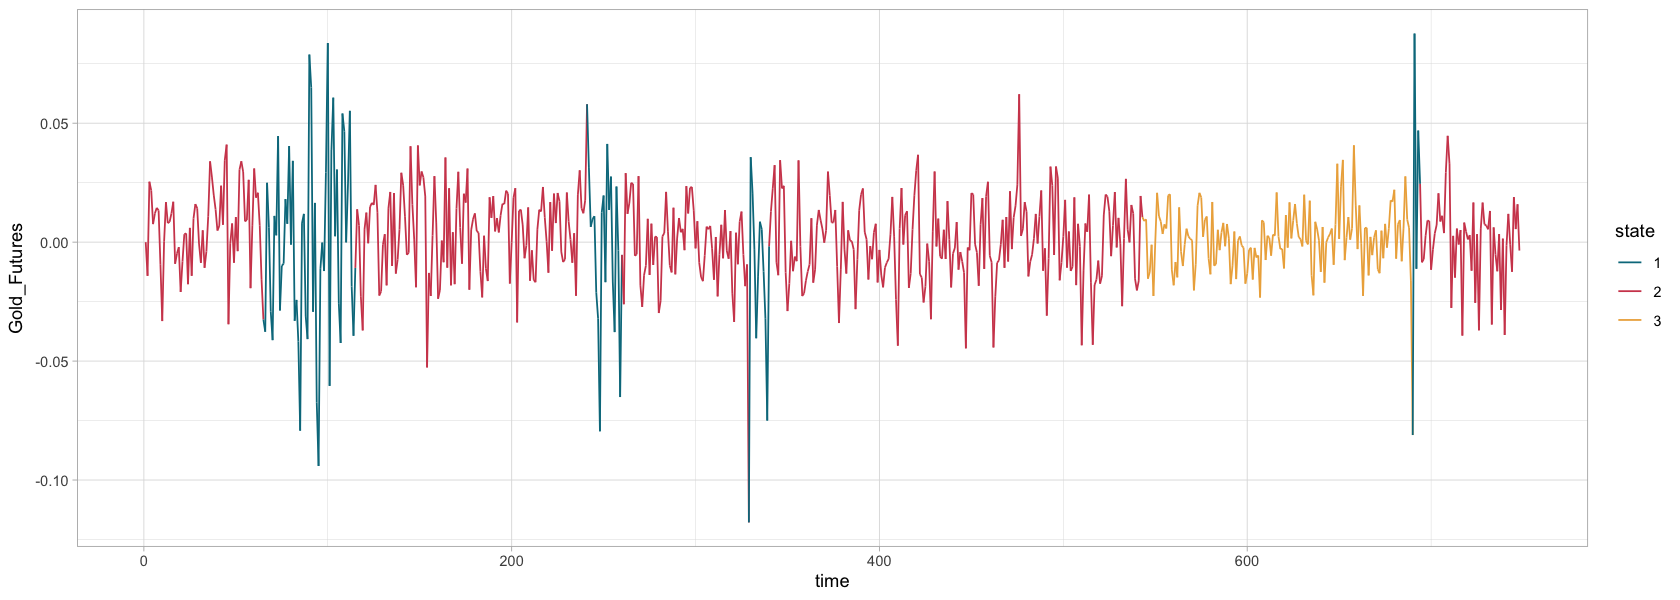

In [8]:
options(repr.plot.width = 14, repr.plot.height = 5)
models$Gold_Futures$plot_ts("Gold_Futures")

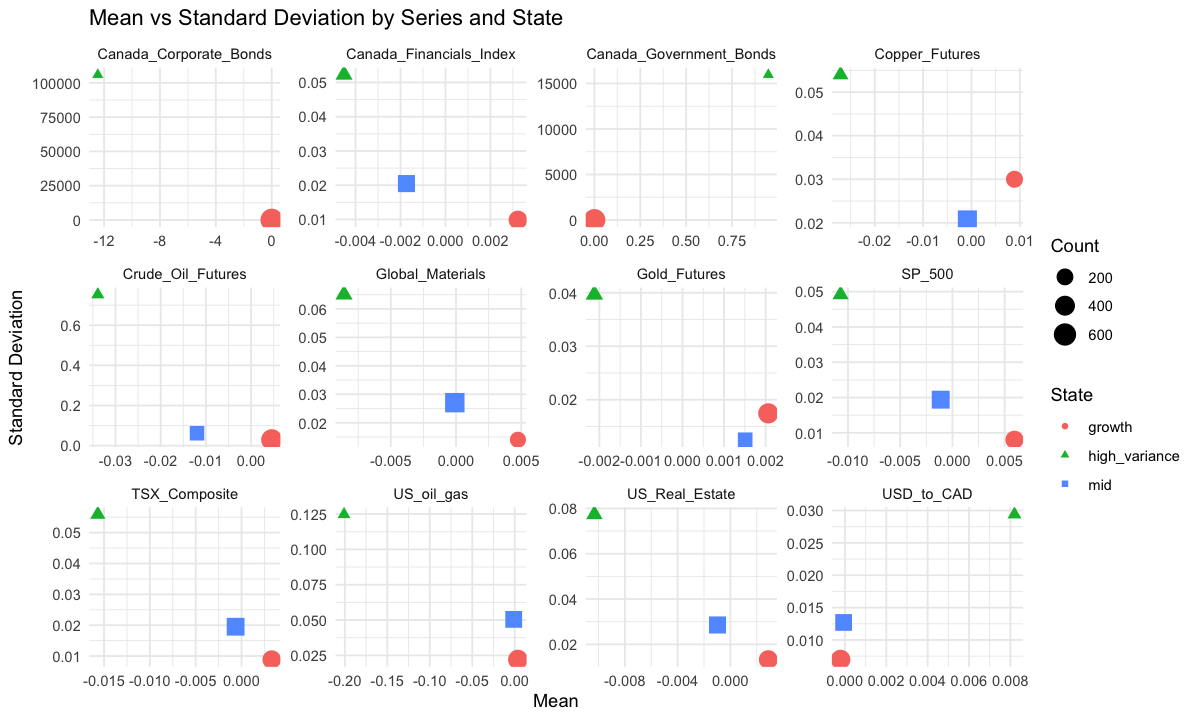

In [6]:
# Convert par_list to a data frame for plotting
par_df <- do.call(rbind, lapply(names(par_list), function(name) {
  data.frame(
    Series = name,
    State = par_list[[name]][, "state_label"],
    mean = as.numeric(par_list[[name]][, "mean"]),
    sd = as.numeric(par_list[[name]][, "sd"]),
    count = as.numeric(par_list[[name]][, "count"])
  )
}))
options(repr.plot.width = 10, repr.plot.height = 6)
# Plot mean vs sd with facets for each series
ggplot(par_df, aes(x = mean, y = sd, size = count, color = factor(State), shape = factor(State))) +
  geom_point() +
  facet_wrap(~ Series, scales = "free") +
  labs(title = "Mean vs Standard Deviation by Series and State",
       x = "Mean",
       y = "Standard Deviation",
       color = "State",
       shape = "State",
       size = "Count") +
  scale_size_continuous(range = c(2, 6)) +
  theme_minimal()

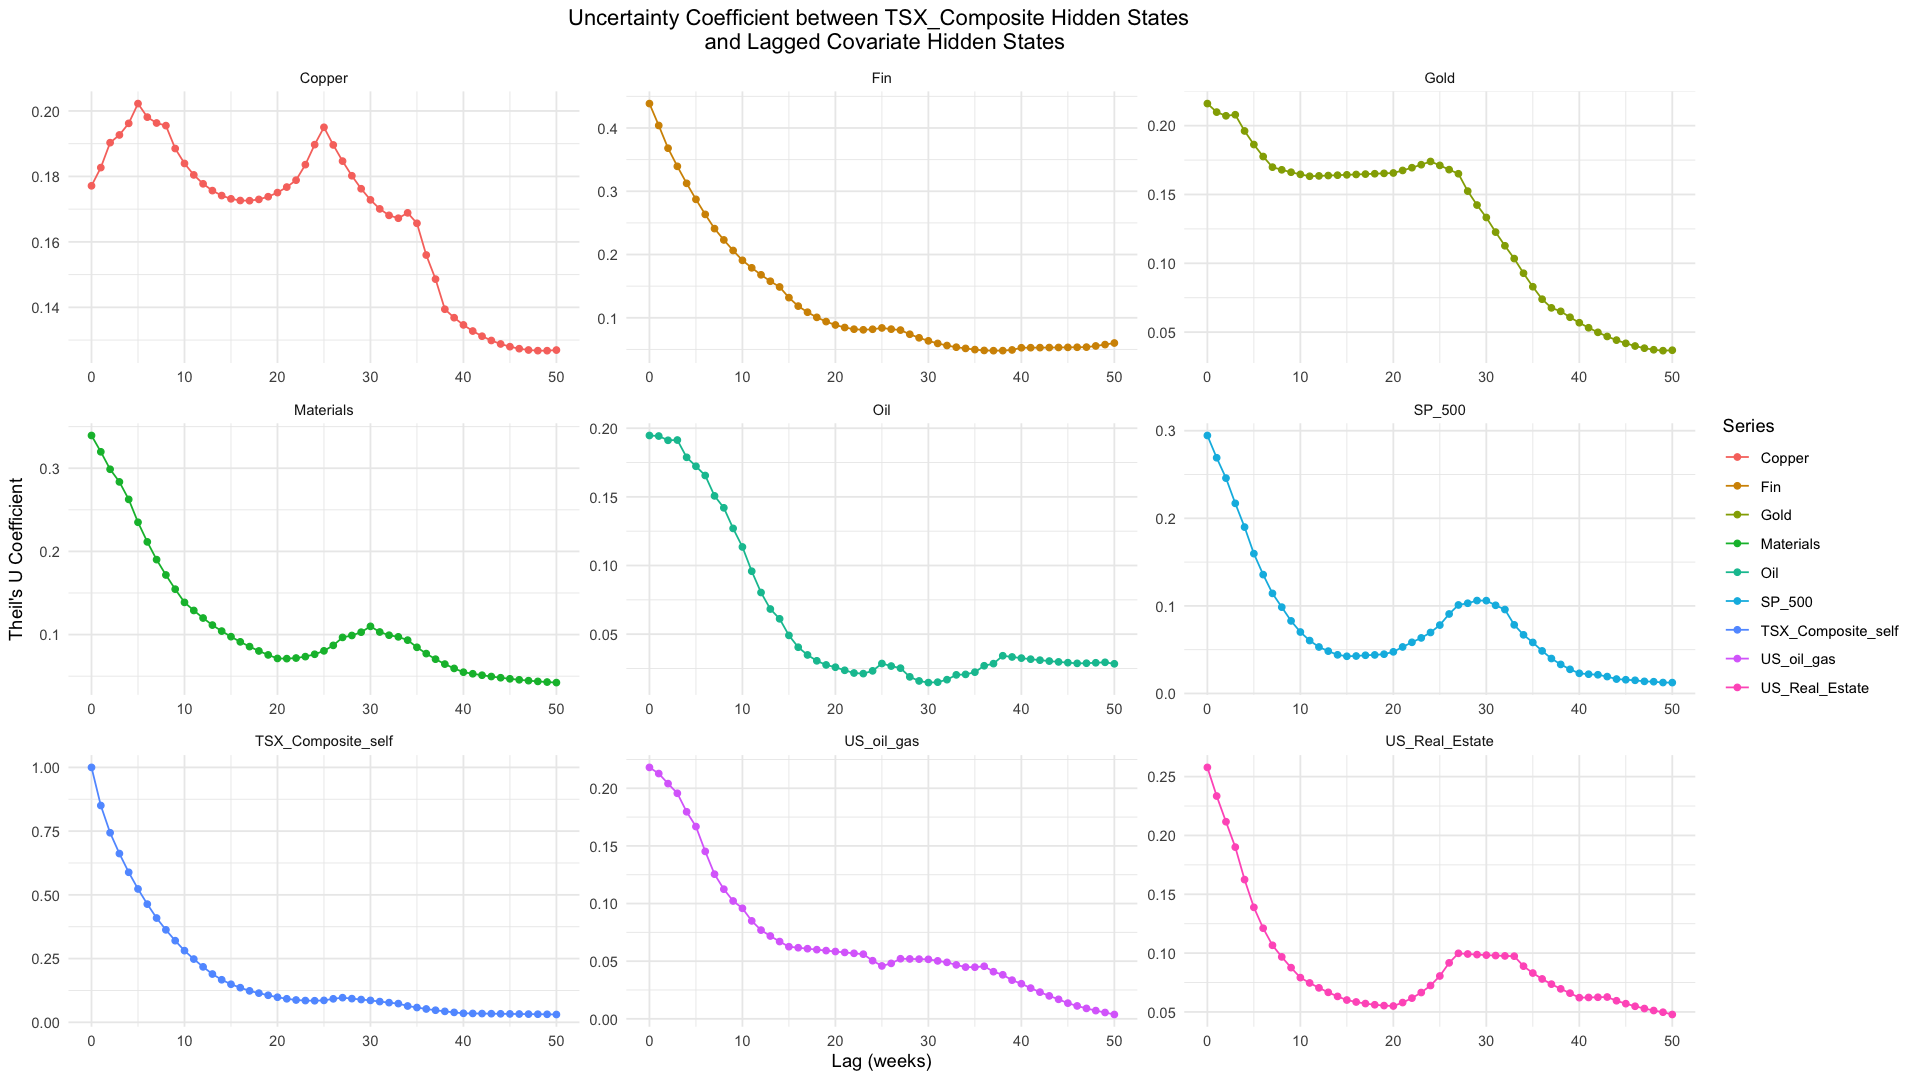

In [11]:
library(dplyr)
library(ggplot2)
library(tidyr)

# Extract the relevant series (assuming no leading/trailing NAs; filter if needed)
tsx <- recoded_df$TSX_Composite
fin <- recoded_df$Canada_Financials_Index
oil <- recoded_df$Crude_Oil_Futures
gold <- recoded_df$Gold_Futures
copper <- recoded_df$Copper_Futures
materials <- recoded_df$Global_Materials
bonds <- recoded_df$Canada_Government_Bonds
us_real_estate <- recoded_df$US_Real_Estate
sp500 <- recoded_df$SP_500
usd_cad <- recoded_df$USD_to_CAD
us_oil <- recoded_df$US_oil_gas

# Define the maximum lag (adjust as needed, e.g., 200 for approximately 4 years of weekly data)
max_lag <- 50

# Function to compute correlations for lags 0 to max_lag
compute_cor_lags <- function(series1, series2, max_lag, method = "theil") {
  lags <- 0:max_lag
  corrs <- sapply(lags, function(lag) {
    series2_shifted <- lag(series2, n = lag)
    if (method %in% c("pearson", "spearman", "kendall")) {
      return(cor(series1, series2_shifted, method = method, use = "complete.obs"))
    } else if (method == "theil") {
      return(UncertCoef(x=as.factor(series2_shifted), y=as.factor(series1)))
    } else {
      stop("Unsupported correlation method")
    }

  })
  corrs
}

# Compute correlations for each series
lags <- 0:max_lag
plot_data <- data.frame(lag = lags)
plot_data$TSX_Composite_self <- compute_cor_lags(tsx, tsx, max_lag)
plot_data$Fin <- compute_cor_lags(tsx, fin, max_lag)
plot_data$Oil <- compute_cor_lags(tsx, oil, max_lag)
plot_data$Gold <- compute_cor_lags(tsx, gold, max_lag)
plot_data$Copper <- compute_cor_lags(tsx, copper, max_lag)
plot_data$Materials <- compute_cor_lags(tsx, materials, max_lag)
#plot_data$Bonds <- compute_cor_lags(tsx, bonds, max_lag)
plot_data$US_Real_Estate <- compute_cor_lags(tsx, us_real_estate, max_lag)
plot_data$SP_500 <- compute_cor_lags(tsx, sp500, max_lag)
#plot_data$USD_to_CAD <- compute_cor_lags(tsx, usd_cad, max_lag)
plot_data$US_oil_gas <- compute_cor_lags(tsx, us_oil, max_lag)

#plot_data$Gold_norm <- compute_cor_lags(tsx, gold, max_lag)

# Convert to long format for plotting
plot_data_long <- plot_data %>%
  pivot_longer(cols = -lag, names_to = "Series", values_to = "correlation")
  
options(repr.plot.width = 16, repr.plot.height = 9)
# Plot the results
ggplot(plot_data_long, aes(x = lag, y = correlation, color = Series)) +
  geom_line() +
  facet_wrap(~ Series, scales = "free") +
  geom_point(size = 1.5) +
  labs(title = "Uncertainty Coefficient between TSX_Composite Hidden States \n and Lagged Covariate Hidden States",
       x = "Lag (weeks)",
       y = "Theil's U Coefficient") +
  theme_minimal() +
  theme(plot.title = element_text(hjust = 0.5))

In [13]:
train_size <- corelation_window
test_size <- 8
samples <- 5
splits <- train_test_split(
  close_data,
  training_period = train_size,
  testing_period = test_size,
  samples = samples
)
log_train <- lapply(splits$train, function(x) ln_transform(x))
log_test <- lapply(seq_along(splits$test), function(i) ln_transform(splits$test[[i]], previous_row = tail(splits$train[[i]], 1)))

train_data <- log_train[[1]]
test_data <- log_test[[1]]

head(train_data, 3)
head(test_data, 3)

,TSX_Composite,Canada_Financials_Index,Crude_Oil_Futures,Gold_Futures,Copper_Futures,USD_to_CAD,Canada_Corporate_Bonds,Canada_Government_Bonds,US_oil_gas,Global_Materials,US_Real_Estate,SP_500
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.00000000,0.000000000,0.00000000,0.00000000,0.00000000,0.000000000,0.0000000000,0.000000000,0.000000000,0.00000000,0.00000000,0.000000000
2,-0.01164651,-0.011632406,-0.06601378,-0.01415782,-0.03803347,0.003206809,-0.0006939892,-0.001240555,-0.008137387,-0.00909280,0.01302906,0.004569601
3,0.01427461,0.008381472,-0.05008433,0.02541448,-0.02542768,-0.001312185,-0.0021842862,-0.002983604,0.015887324,0.01784451,0.03342427,0.006990459


,TSX_Composite,Canada_Financials_Index,Crude_Oil_Futures,Gold_Futures,Copper_Futures,USD_to_CAD,Canada_Corporate_Bonds,Canada_Government_Bonds,US_oil_gas,Global_Materials,US_Real_Estate,SP_500
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.004305880,0.007158860,0.0252689419,0.01479005,0.01325970,-0.008878027,1.842289e-03,0.0027434964,0.05689430,0.022526080,-0.004872025,0.0004162301
2,-0.001759266,0.005424377,0.0001536452,0.01760384,0.02706173,-0.008634028,-4.057554e-03,-0.0042097884,0.01531107,0.014012597,-0.012440151,-0.0126783339
3,0.013409113,0.017363475,-0.0146083037,0.02346219,-0.02179373,-0.003206985,9.238458e-05,-0.0006421521,0.01582456,-0.007830403,0.007872742,0.0019937268


In [14]:
source("markets_functions.R") 

obs_name <- "TSX_Composite"
n_states <- 3
eval_range <- seq(from = -0.2, to = 0.2, by = 0.001)

state_logloss <- list()
prediction_logloss <- list()
for (i in seq_len(samples)) {
  train_data <- log_train[[i]]
  test_data <- log_test[[i]]
  combined <- rbind(train_data, test_data)

  hmm <- fit_hmm(
    data = train_data,
    obs_name = obs_name,
    n_states = n_states,
    hid_formula = as.formula("~1"),
    horseshoe = FALSE,
  )
  forecast <- Forecast$new(
    hmm = hmm,
    forecast_data = test_data,
    starting_state_distribution = "last",
    preset_eval_range = setNames(list(eval_range), obs_name)
  )
  true_model <- fit_hmm(
    data = combined,
    obs_name = obs_name,
    n_states = n_states,
    hid_formula = as.formula("~1"),
    horseshoe = FALSE,
    init = hmm
  )
  # Get State forecast log loss
  forecast_states <- matrix(forecast$hidden_state_forecast(), ncol = n_states, byrow = TRUE)
  true_states <- true_model$state_probs()[(1+nrow(train_data)):nrow(combined), ]

  state_cross_entropy <- -rowSums(true_states * log(forecast_states + 1e-10))
  state_logloss[[i]] <- state_cross_entropy

  # Get overall prediction log loss
  forecast_dists <- forecast$forecast_dists()[[obs_name]]
  eval_range <- forecast$eval_range()[[obs_name]]
  logloss <- list()
  for (j in seq_len(nrow(test_data))) {
    pdf_val <- approx(
      x = eval_range,
      y = forecast_dists[, j],
      xout = test_data[[obs_name]][j]
    )$y
    logloss[[j]] <- -log(pdf_val)
  }
  prediction_logloss[[i]] <- as.numeric(logloss)
}


In [15]:
source("markets_functions.R") 

obs_name <- "TSX_Composite"
cov_name <- "Crude_Oil_Futures"
n_states <- 3
eval_range <- seq(from = -0.2, to = 0.2, by = 0.001)

cov_state_logloss <- list()
cov_prediction_logloss <- list()
for (i in seq_len(samples)) {
  train_data <- log_train[[i]]
  test_data <- log_test[[i]]
  covariate <- fit_hmm(
      data = train_data,
      obs_name = cov_name,
      n_states = n_states,
      hid_formula = as.formula("~1"),
      horseshoe = FALSE,
    )
  cov_states <- covariate$state_probs()
  colnames(cov_states) <- paste0(cov_name, "_State_", 1:n_states)

  obs_train <- lead(train_data[obs_name], n = test_size)

  cov_data <- cbind(obs_train, cov_states)
  cov_train <- cov_data[1:(train_size - test_size), ]
  cov_test <- cov_data[(train_size - test_size + 1):train_size, ]

  formula <- as.formula(
    paste0(
      " ~1 + ",
      paste(colnames(cov_states), collapse = " + ")
    )
  )
  hmm <- fit_hmm(
    data = cov_train,
    obs_name = obs_name,
    n_states = n_states,
    hid_formula = formula,
    horseshoe = FALSE,
  )
  forecast <- Forecast$new(
    hmm = hmm,
    forecast_data = cov_test,
    starting_state_distribution = "last",
    preset_eval_range = setNames(list(eval_range), obs_name)
  )

  cov_test[[obs_name]] <- test_data[[obs_name]]
  combined_data <- rbind(cov_train, cov_test)

  true_model <- fit_hmm(
    data = combined_data,
    obs_name = obs_name,
    n_states = n_states,
    hid_formula = formula,
    horseshoe = FALSE,
    init = hmm
  )

  forecast_states <- matrix(forecast$hidden_state_forecast(), ncol = n_states, byrow = TRUE)
  true_states <- true_model$state_probs()[(1+train_size - test_size):train_size, ]

  state_cross_entropy <- -rowSums(true_states * log(forecast_states + 1e-10))
  cov_state_logloss[[i]] <- state_cross_entropy

  # Get overall prediction log loss
  forecast_dists <- forecast$forecast_dists()[[obs_name]]
  eval_range <- forecast$eval_range()[[obs_name]]
  logloss <- list()
  for (j in seq_len(nrow(test_data))) {
    pdf_val <- approx(
      x = eval_range,
      y = forecast_dists[, j],
      xout = test_data[[obs_name]][j]
    )$y
    logloss[[j]] <- -log(pdf_val)
  }

  cov_prediction_logloss[[i]] <- as.numeric(logloss)
}

Warning message in hmm$fit(silent = TRUE):
“Convergence code was not zero, indicating that the optimizer may not have converged to the correct estimates. Please check by consulting the out() function which shows what nlminb returned.”


In [16]:
plot_logloss <- function(..., title) {
  # Capture the call to extract argument names
  call <- match.call(expand.dots = FALSE)
  arg_names <- names(call$...)  # Get names of the ... arguments
  loss_lists <- list(...)
  n_groups <- length(loss_lists)
  if (n_groups < 1) stop("At least one loss_list is required.")

  # Compute statistics for each group
  stats <- lapply(loss_lists, function(loss_list) {
    mat <- do.call(rbind, loss_list)
    m <- colMeans(mat, na.rm = TRUE)
    q90 <- apply(mat, 2, quantile, probs = c(0.05, 0.95), na.rm = TRUE)
    list(mat = mat, m = m, lower = q90[1, ], upper = q90[2, ])
  })

  # Assume all groups have the same number of time points
  t_max <- length(stats[[1]]$m)
  if (!all(sapply(stats, function(s) length(s$m) == t_max))) {
    stop("All loss_lists must have the same number of time points.")
  }

  # Determine overall y-range
  all_bounds <- unlist(lapply(stats, function(s) c(s$lower, s$upper)))
  ylim <- range(all_bounds, na.rm = TRUE)

  # Time points
  x <- seq_len(t_max)

  # Set up empty plot
  plot(x, type = "n", ylim = ylim, xlab = "t", ylab = "cross-entropy")
  title(main = title)

  # Define colors (using rainbow for automatic differentiation; adjust as needed)
  colors <- rainbow(n_groups)

  # Group names: use provided argument names if available, else "Group x"
  group_names <- ifelse(is.null(arg_names) | arg_names == "", 
                        paste("Group", seq_len(n_groups)), 
                        arg_names)

  # Plot each group
  for (i in seq_len(n_groups)) {
    s <- stats[[i]]
    col <- colors[i]

    # Individual series lines only if single group
    if (n_groups == 1) {
      apply(s$mat, 1, function(row) lines(x, row, col = adjustcolor(col, 0.6)))
    }

    # Confidence band
    polygon(c(x, rev(x)), c(s$upper, rev(s$lower)),
            col = adjustcolor(col, 0.2), border = NA)

    # Mean line
    lines(x, s$m, col = col, lwd = 2)
  }

  # Add legend
  legend("topright", legend = group_names, fill = colors, title = "Groups")
}

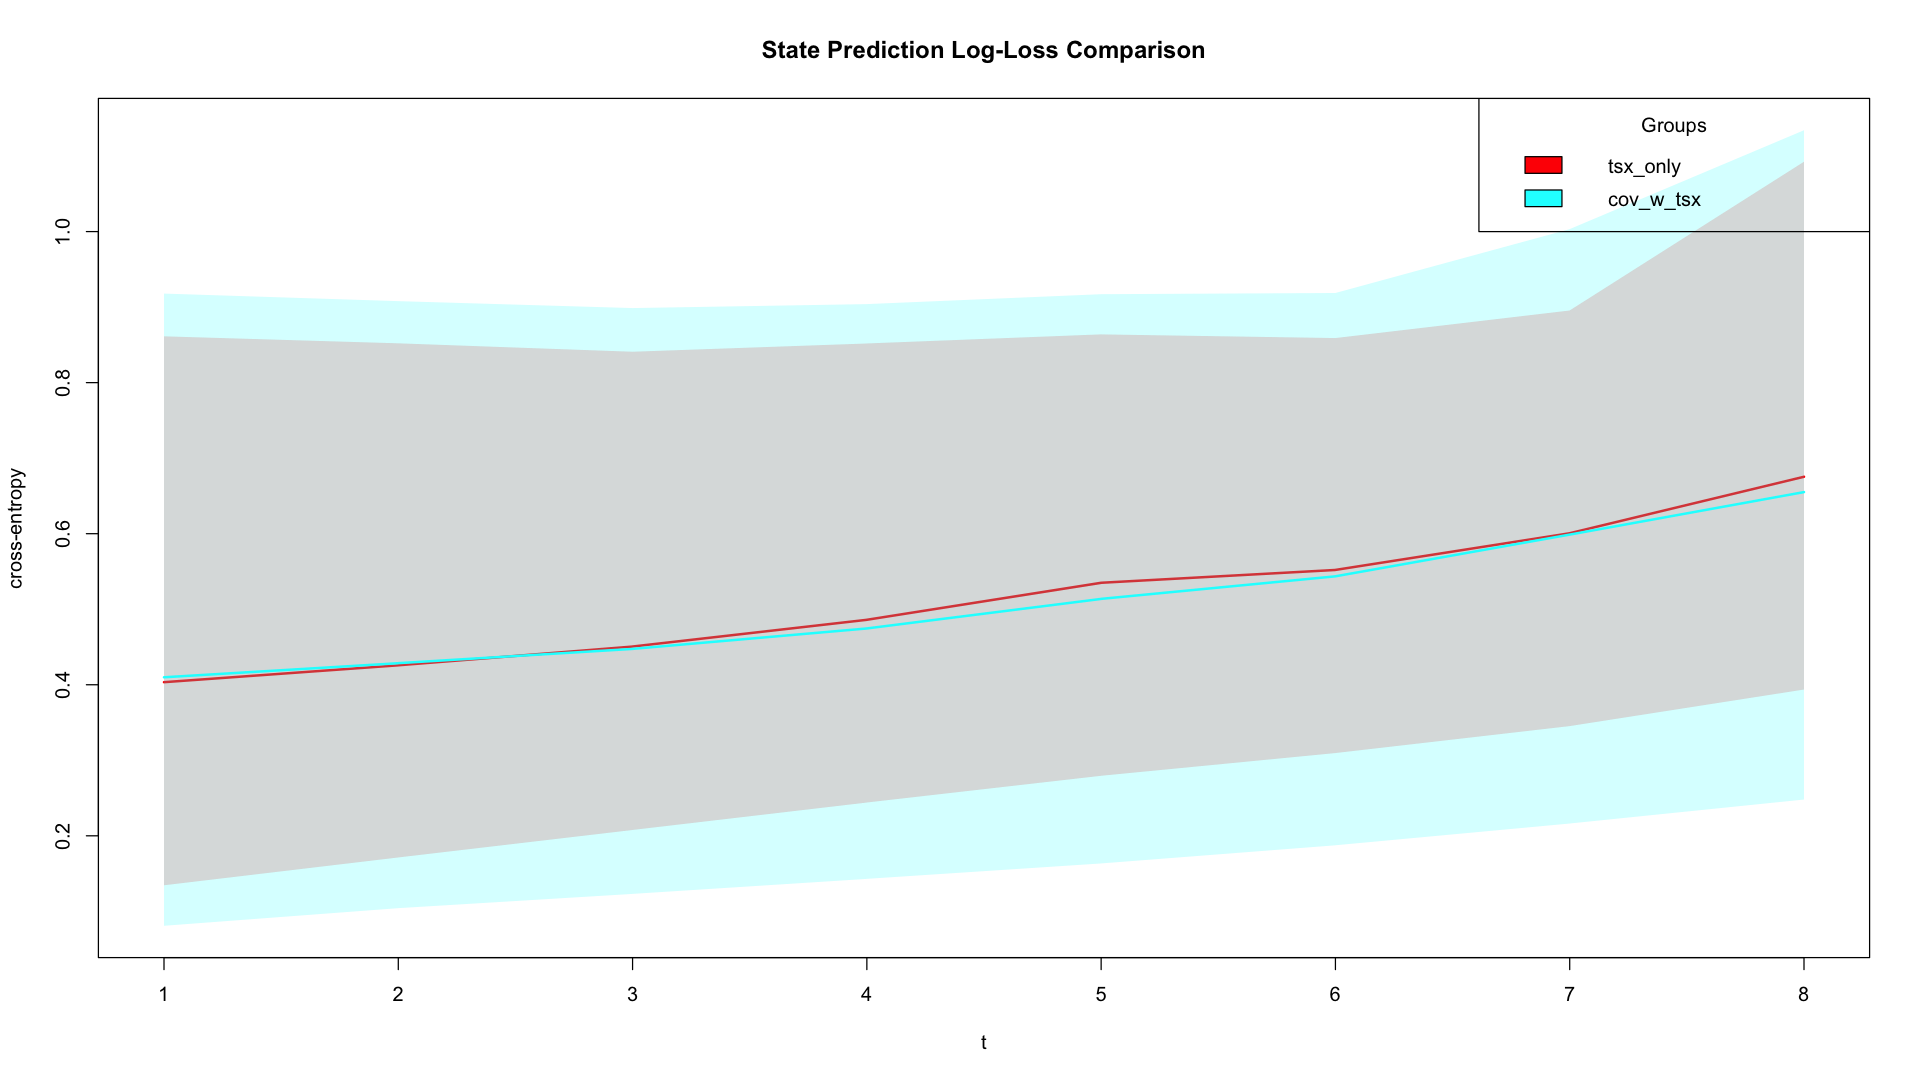

In [17]:
plot_logloss(tsx_only = state_logloss, cov_w_tsx = cov_state_logloss, title = "State Prediction Log-Loss Comparison")

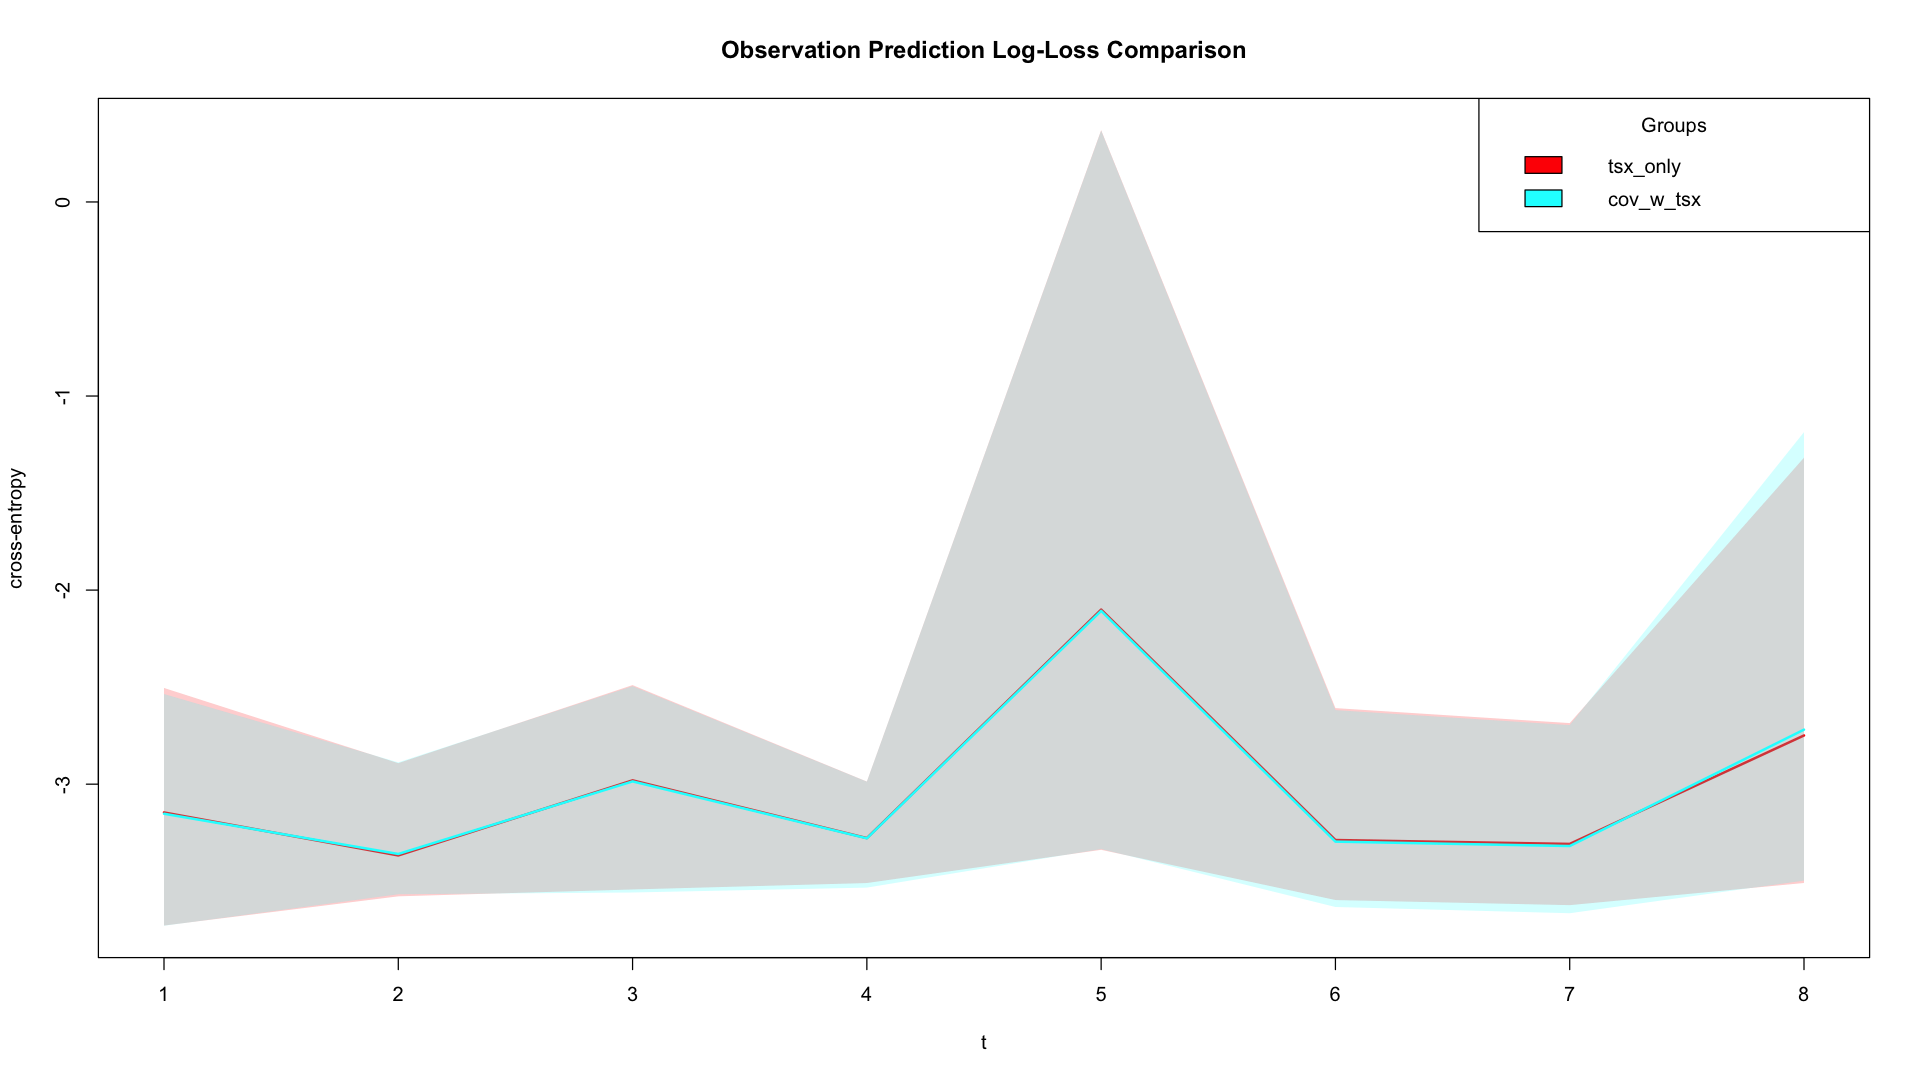

In [18]:
plot_logloss(tsx_only = prediction_logloss, cov_w_tsx = cov_prediction_logloss, title = "Observation Prediction Log-Loss Comparison")

In [19]:
hmm$coeff_fe()

TSX_Composite.mean.state1.(Intercept),-0.093778704
TSX_Composite.mean.state2.(Intercept),-0.001268230
TSX_Composite.mean.state3.(Intercept),0.003125086
TSX_Composite.sd.state1.(Intercept),-2.852757707
TSX_Composite.sd.state2.(Intercept),-3.906328136
TSX_Composite.sd.state3.(Intercept),-4.689036195
S1>S2.(Intercept),-56.4572123
S1>S2.Crude_Oil_Futures_State_1,6.2221048
S1>S2.Crude_Oil_Futures_State_2,76.9138412
S1>S2.Crude_Oil_Futures_State_3,-136.7027865
S1>S3.(Intercept),-25.6727264
